In [1]:
from model_manager import model_generator, model_trainer, model_storage, model_evaluation
import json
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from data_manager import data_preprocessor as preproc
from data_manager import fixed_splitter as fs
from grapher import graph_generator as gg
from keras import ops


import tensorflow as tf
import tensorflow_probability as tfp
import sklearn.metrics as sk




'''Open train config...'''
print("Opening train config file...")
TRAINER_CONFIG_FILE_LOCATION = 'config/trainer_config.json'
with open(TRAINER_CONFIG_FILE_LOCATION, 'r') as file:
    train_config = json.load(file)

model_type = train_config["model_files"]["model_type"]




print("preprocessing background data...")
background_data = preproc.get_data(train_config) # get background data
print("normalizing background data...")
background_data = preproc.normalize_data(background_data) # normalize background data
print("preprocessing signal data...")
signal_data = preproc.get_signal_data(train_config) # get signal data
print("normalizing signal data...")
signal_data = preproc.normalize_signal_data(signal_data) # normalize signal data







# split bg data into train, validate, and test sets.
print("splitting background data...")
data_train, data_validate, data_test = fs.generate_fixed_trainingdata_split(train_config, background_data, True)






# create model
print("initializing model...")
model = model_generator.create_model(train_config, model_type)





# train model
print("training model...")
model, history = model_trainer.train_model(train_config, model, data_train, data_validate, model_type)


2025-08-19 08:49:38.074458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 08:49:38.079644: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 08:49:38.092474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755618578.113721  835010 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755618578.120049  835010 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755618578.136714  835010 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Opening train config file...
preprocessing background data...
normalizing background data...
preprocessing signal data...
normalizing signal data...
splitting background data...
Generated The Following Datasets
 Train Data Shape : (2000000, 57)
 Validation Data Shape : (399999, 57)
 Test Data Shape : (50000, 57)
initializing model...


2025-08-19 08:51:09.547321: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


training model...
(2000000, 2)
(399999, 2)
training EDL model
Epoch 1/3


NameError: Exception encountered when calling EDLModel.call().

[1mname 'kl_strengh' is not defined[0m

Arguments received by EDLModel.call():
  • inputs=('tf.Tensor(shape=(None, 57), dtype=float32)', 'tf.Tensor(shape=(None, 2), dtype=float32)')

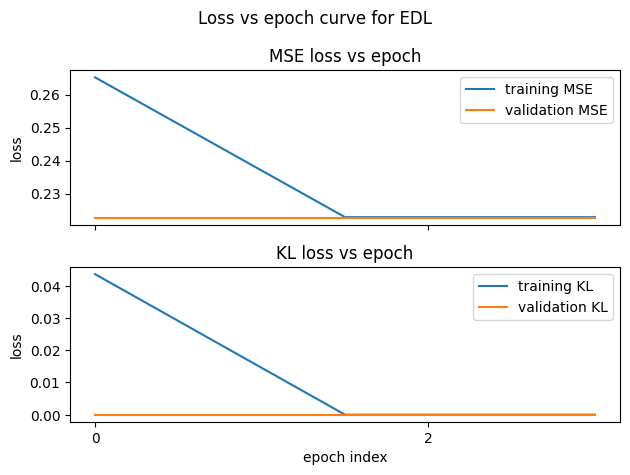

0.0
0.0
0.0
0.0
0.0


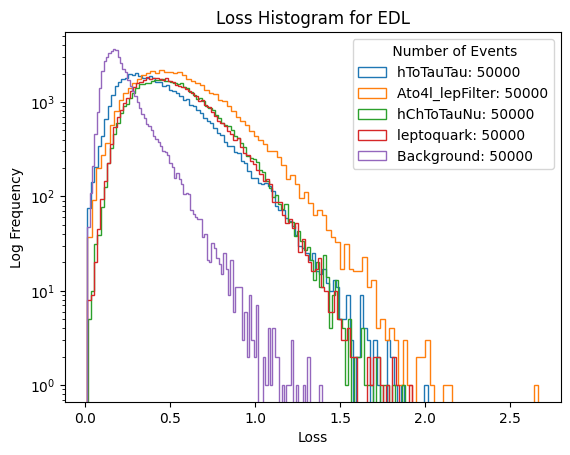

0.0
0.0
0.0
0.0
0.0


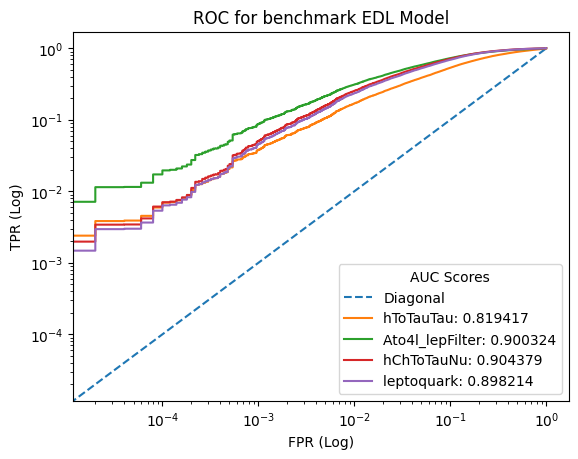

In [ ]:
gg.generate_loss_vs_epoch(train_config, history, model_type)
gg.generate_loss_histogram(train_config, model, data_test, signal_data)
gg.generate_roc_curve(train_config, model, data_test, signal_data)

This cell is still having some issues

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step


/sdf/home/b/begeldan/evidential-dl-ae/.venv/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/sdf/home/b/begeldan/evidential-dl-ae/.venv/lib64/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

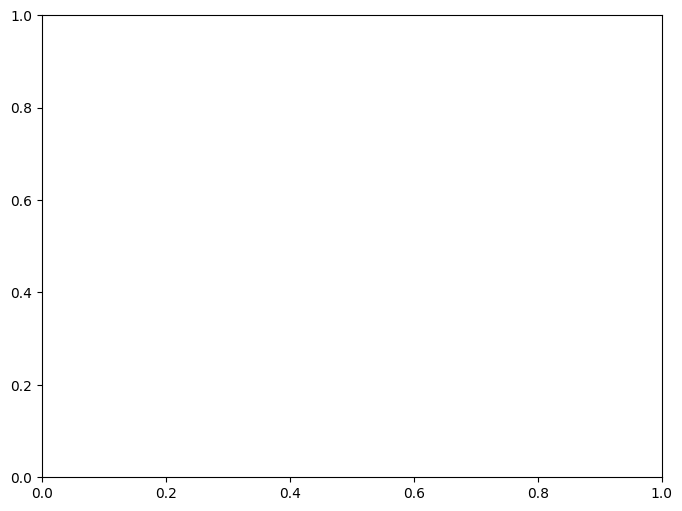

In [ ]:
def calculate_probability_uncertainity(train_config, alpha):
    
    alpha = np.array(alpha, dtype=np.float32) # make sure alpha is the correct datatype
    
    S = np.sum(alpha, axis=1, keepdims=True) # alpha concentration
    probs = alpha / S # calculate class probabilities

    K = train_config["encoder_design"]["latent_layer_dimension"] # K = 2 for binary classification
    uncertainty = K / S # calculate uncertainty

    return probs, S, uncertainty

def generate_probability_distribution_hist(train_config, probs_list, labels):
    plt.figure(figsize=(8,6))
    for i, data in enumerate(probs_list):
        anomaly_probs = data[:, 1]
        plt.hist(
            anomaly_probs, 
            histtype='step', 
            bins=train_config["outputs"]["bins"], 
            label=labels[i] 
        )
    plt.xlabel('Probability')
    plt.ylabel('Log Frequency')
    plt.yscale('log')
    plt.title("EDL probability distribution")
    plt.legend()
    # plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
    #         train_config["outputs"]["date_time_format"]) + "KL_Histogram.png"), format="png", bbox_inches="tight")
    plt.show()

def generate_uncertainty_distribution_hist(train_config, uncertainty_list, labels):
    plt.figure(figsize=(8,6))
    for i, data in enumerate(uncertainty_list):
        plt.hist(
            data,
            histtype='step', 
            bins=train_config["outputs"]["bins"], 
            label=labels[i]
        )
    plt.xlabel('Probability')
    plt.ylabel('Log Frequency')
    plt.yscale('log')
    plt.title("Uncertainty distribution for " + train_config["model_files"]["model_type"])
    plt.legend()
    # plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
    #         train_config["outputs"]["date_time_format"]) + "KL_Histogram.png"), format="png", bbox_inches="tight")
    plt.show()


if model_type == "EDL":
    uncertainty_list = []
    probs_list = []
    z, alpha = model.encoder.predict(data_test)
    probs_background, S, uncertainty_background = calculate_probability_uncertainity(train_config, alpha)
    probs_list.append(probs_background)
    uncertainty_list.append(uncertainty_background)

    # Signal
    labels = train_config["data_files"]["signal_labels"]
    signal_probability_list = []
    for i in range(len(signal_data)):
        z, alpha = model.encoder.predict(signal_data[i])
        probs_signal, S, uncertainty_signal = calculate_probability_uncertainity(train_config, alpha)
        probs_list.append(probs_signal)
        uncertainty_list.append(uncertainty_signal)

    # Plot all of the probabilities on one plot
    generate_probability_distribution_hist(train_config, probs_list, ["Background"] + labels)
    # Plot Latent Space for all of the uncertainities on one plot
    generate_uncertainty_distribution_hist(train_config, uncertainty_list, ["Background"] + labels)

